# Dataloader

In [35]:
from pathlib import Path

import numpy as np
from numpy import random
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import torch
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import to_networkx

import matplotlib.pyplot as plt
import networkx as nx

from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, EdgesAndLinkedNodes
from bokeh.palettes import Viridis256, Category20_20, viridis
from bokeh.plotting import figure, from_networkx
from bokeh.io import output_notebook, show
output_notebook()

import logging
logger = logging.getLogger(__name__)

Loading BokehJS ...

In [36]:
def _start_logging():
    logging.basicConfig(filename='tests.log', filemode='w', level=logging.INFO, force=True,
                        format='%(asctime)s %(levelname)s %(module)s.%(funcName)s - %(message)s')
    logger.info('Started logging')

    # logger.debug('This is a debug message')
    # logger.info('This is an info message')
    # logger.warning('This is a warning message')
    # logger.error('This is an error message')
    # logger.critical('This is a critical message')
_start_logging()

# Plots

In [37]:
def plot_histograms(arrays, bins=30, figsize=(6, 1), max_height=20, title=None):
    """
    Plot histograms for a list of numpy arrays in a single column.

    Parameters:
    arrays (list of np.array): List of numpy arrays to plot.
    bins (int): Number of bins for the histograms.
    figsize (tuple): Size of the figure. The height is multiplied
        by the number of arrays to plot.
    max_height (int): Maximum height of the figure in inches.
    """
    num_arrays = len(arrays)
    figsize = (figsize[0], min(figsize[1]*(1+num_arrays), max_height))
    _, axes = plt.subplots(num_arrays, 1, figsize=figsize, sharex=True)

    if num_arrays == 1:
        axes = [axes]

    for i, data_ in enumerate(arrays):
        axes[i].hist(data_, bins=bins, edgecolor='black')
        axes[i].set_ylabel('Freq.')

    if title is not None:
        axes[0].set_title(title)

    axes[-1].set_xlabel('Value')
    plt.tight_layout()
    plt.show()

In [38]:
def print_graph(graph, fig_size=(4,4)):
    """Static plot of the given graph with Bokeh.."""
    vis = to_networkx(graph)

    node_index = list(range(graph.num_nodes))

    plt.figure(1,figsize=fig_size)
    nx.draw(vis, cmap=plt.get_cmap('Set3'), node_color = node_index, node_size=70, linewidths=6)
    plt.show()

In [39]:
def plot_graph(graph, width=400, height=400, layout=None):
    """
    Interactive plot of the given graph with Bokeh.

    Source: https://docs.bokeh.org/en/latest/docs/user_guide/topics/graph.html
    """
    p = figure(
        width=width, height=height,
        x_range=(-1.2, 1.2), y_range=(-1.2, 1.2),
        x_axis_location=None, y_axis_location=None,
        tools="hover,pan,wheel_zoom,box_zoom,save,reset,help",
        tooltips="")
    p.grid.grid_line_color = None

    hover = HoverTool()
    hover.tooltips = [("index", "$index")]
    for k in g.node_attrs():
        hover.tooltips.append((k, f'@{k}'))
    p.add_tools(hover)

    graph_x = to_networkx(graph, node_attrs=['x'], edge_attrs=['edge_attr'])
    if layout is None:
        layout = nx.spring_layout
    graph_viz = from_networkx(graph_x, layout, scale=1.0, center=(0,0))
    p.renderers.append(graph_viz)

    graph_viz.node_renderer.data_source.data['index'] = list(range(graph.num_nodes))
    graph_viz.node_renderer.data_source.data['colors'] =  viridis(graph.num_nodes)
    graph_viz.edge_renderer.glyph = MultiLine(line_color="gray", line_alpha=0.8, line_width=3)
    graph_viz.node_renderer.glyph.update(size=15, fill_color="colors")

    show(p)


# Sample Generation

In [40]:
def _get_random_scale(uniform_range=(1.,1.)):
    rng = np.random.default_rng()
    low = uniform_range[0]
    high = uniform_range[1]
    return rng.uniform(low=low, high=high, size=1)

def number_generator(size=1, uniform_range=(1.,1.), log_=False):
    """
    Generates random numbers with a probabilistic range.

    The mean of the random numbers is drawn from a uniform distribution
    between -1 and 1. The range of the random numbers is drawn from a
    uniform distribution. The range of the range is given by the
    `uniform_range` parameter.

    Parameters:
    size (int): Number of random numbers to generate.
    uniform_range (tuple): Limits of the range for the random numbers.
        Draws from a uniform distribution.
    log_ (bool): If True, writes results to log file.
    """
    rng = np.random.default_rng()
    range_ = _get_random_scale(uniform_range)
    mean = rng.uniform(low=-1, high=1, size=1)
    if log_:
        logger.info(f'mean: {mean[0]:.4g}')
        logger.info(f'range: {range_[0]:.4g}')
    return rng.uniform(low=mean-0.5*range_, high=mean+0.5*range_, size=size)

# data_ = []
# for _ in range(10):
#     data_.append(number_generator(1000, uniform_range=(0.1,10.), log_=True))
# plot_histograms(data_, bins=30)

In [41]:
def _get_diagonals(number_generator,
                  rank=5,
                  off_diagonal_abs_mean=0.5,
                  symmetric=False,
                  uniform_range=(0.1,10.),
                  log_=False):

    if rank < 3:
        raise ValueError("Rank must be at least 3")

    n_diag_1 = rank-1
    n_diag_2 = rank-2

    n_ = 1 if symmetric else 2
    data_ = number_generator(n_*(n_diag_1 + n_diag_2), uniform_range=uniform_range, log_=log_)

    mean_abs = np.abs(data_).mean()
    alpha = off_diagonal_abs_mean / mean_abs
    data_ = data_ * alpha

    if log_:
        logger.info(f'Abs mean: {mean_abs:.4g}')
        logger.info(f'Alpha: {alpha:.4g}')
        logger.info(f'New abs mean: {np.abs(data_).mean():.4g}')

    diag_1_u = data_[:n_diag_1]
    diag_2_u = data_[n_diag_1: n_diag_1+n_diag_2]

    diag_1_l = data_[(n_-1)*(n_diag_1+n_diag_2): n_*n_diag_1+n_diag_2]
    diag_2_l = data_[(n_-1)*(n_diag_1+n_diag_2) + n_diag_1: n_*(n_diag_1+n_diag_2)]

    return [diag_2_u, diag_1_u, diag_1_l, diag_2_l]

# data_ = []
# for _ in range(10):
#     diag_ = _get_diagonals(number_generator, rank=50, off_diagonal_abs_mean=5.0, symmetric=False, uniform_range=(0.1,10.), log_=True)
#     data_.append(np.concat(diag_))
# plot_histograms(data_, bins=30)

In [42]:
def _matrix_from_diags(data_):
    diag_2_u, diag_1_u, diag_1_l, diag_2_l = data_
    n_diag = diag_1_u.shape[0] + 1
    main_diag = np.ones(n_diag)
    data__ = [diag_2_l, diag_1_l, main_diag, diag_1_u, diag_2_u]
    offsets = [-2, -1, 0, 1, 2]
    return diags(data__, offsets, format='csr')

# diag_ = _get_diagonals(number_generator, rank=5, off_diagonal_abs_mean=5.0, symmetric=False, uniform_range=(0.1,10.), log_=False)
# data__ = _matrix_from_diags(diag_)
# print('Matrix')
# print(data__.toarray())

# print('Original diagonals')
# for s,d in zip(['diag_2_u', 'diag_1_u', 'diag_1_l', 'diag_2_l'], diag_):
#     print('  ', s)
#     print('    ', d)

In [43]:
def get_sample(number_generator,
               rank=5,
               off_diagonal_abs_mean=0.5,
               symmetric=False,
               uniform_range=(0.1,10.),
               log_=False):
    """Get a linear system sample."""

    diag_ = _get_diagonals(
        number_generator,
        rank=rank,
        off_diagonal_abs_mean=off_diagonal_abs_mean,
        symmetric=symmetric,
        uniform_range=uniform_range,
        log_=log_)
    matrix_a = _matrix_from_diags(diag_)
    n = matrix_a.shape[0]

    x_true = number_generator(size=n, uniform_range=(1.,1.))
    b = matrix_a.dot(x_true)

    return (matrix_a, x_true, b)

def _get_residual(matrix, x_true, b):
    x_solve = spsolve(matrix, b)
    residual = x_solve - x_true
    return residual

data_ = get_sample(number_generator, rank=5, off_diagonal_abs_mean=0.5, symmetric=False, uniform_range=(0.1,10.), log_=True)
print('Matrix')
try:
    print(data_[0].toarray())
except:
    print(f'Too big to print a {data_[0].shape} matrix.')
print('x_true')
print(data_[1])
print('b')
print(data_[2])

residual = _get_residual(data_[0], data_[1], data_[2])
print(f'Residual: {residual.mean():.4g}')
print(residual)
print(f'  Abs mean: {np.abs(residual).mean():.4g}')

Matrix
[[ 1.         -0.99360676 -0.57758133  0.          0.        ]
 [-0.320906    1.         -0.24594135 -0.4821942   0.        ]
 [ 0.45504159 -0.90679402  1.         -0.60144684  0.28283806]
 [ 0.         -0.13539133 -0.33729324  1.          0.00983825]
 [ 0.          0.         -0.92172468 -0.72940237  1.        ]]
x_true
[1.1611304  0.86681361 0.94322613 0.80258947 0.98428295]
b
[-0.24493126 -0.12478239  0.48124512  0.37677025 -0.47052251]
Residual: 1.776e-16
[ 4.44089210e-16  2.22044605e-16  2.22044605e-16  1.11022302e-16
 -1.11022302e-16]
  Abs mean: 2.22e-16


In [44]:
def _sparse_to_graph(matrix, x_true, b):
    """Generate graph from sparse matrix system of equations."""
    return tg.data.Data(
        x=torch.tensor(b).unsqueeze(1).to(torch.float32),
        edge_index=torch.tensor(np.array(matrix.nonzero())).to(torch.int64),
        edge_attr=torch.tensor(matrix.data).unsqueeze(1).to(torch.float32),
        y=torch.tensor(x_true).unsqueeze(1).to(torch.float32)
        )

data_ = get_sample(number_generator, rank=20, off_diagonal_abs_mean=0.5, symmetric=False, uniform_range=(0.1,10.), log_=False)

g = _sparse_to_graph(*data_)

print(f'Is valid: {g.validate(raise_on_error=True)}')

print(g)

print('keys: ', g.keys())

for key, item in g:
    print(f'  {key} found in graph => {item.shape}')

print(f'g.num_nodes: {g.num_nodes}')
print(f'g.num_edges: {g.num_edges}')
print(f'g.num_node_features: {g.num_node_features}')
print(f'g.has_isolated_nodes(): {g.has_isolated_nodes()}')
print(f'g.has_self_loops(): {g.has_self_loops()}')
print(f'g.is_directed(): {g.is_directed()}')

# Transfer data object to GPU.
device = torch.device('cuda')
g_gpu = g.to(device)

print(f'g_gpu: {g_gpu}')

# for prop in g:
#     print(prop)

Is valid: True
Data(x=[20, 1], edge_index=[2, 94], edge_attr=[94, 1], y=[20, 1])
keys:  ['edge_attr', 'y', 'x', 'edge_index']
  x found in graph => torch.Size([20, 1])
  edge_index found in graph => torch.Size([2, 94])
  edge_attr found in graph => torch.Size([94, 1])
  y found in graph => torch.Size([20, 1])
g.num_nodes: 20
g.num_edges: 94
g.num_node_features: 1
g.has_isolated_nodes(): False
g.has_self_loops(): True
g.is_directed(): True
g_gpu: Data(x=[20, 1], edge_index=[2, 94], edge_attr=[94, 1], y=[20, 1])


Matplotlib


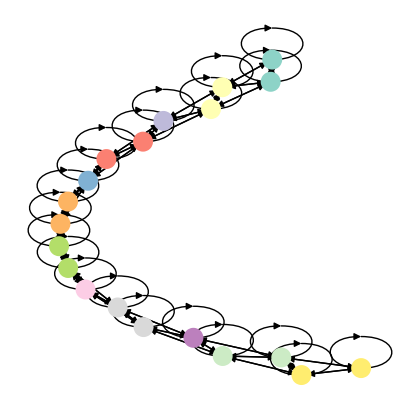


Bokeh
spring_layout


circular_layout


kamada_kawai_layout


shell_layout


spectral_layout


spiral_layout


In [45]:
data_ = get_sample(number_generator, rank=20, off_diagonal_abs_mean=0.5, symmetric=False, uniform_range=(0.1,10.), log_=False)
g = _sparse_to_graph(*data_)

print('Matplotlib')
print_graph(g)

print('\nBokeh')
for p in [
    nx.spring_layout,
    nx.circular_layout,
    nx.kamada_kawai_layout,
    nx.shell_layout,
    nx.spectral_layout,
    nx.spiral_layout,
]:
    print(p.__name__)
    plot_graph(g, layout=p)

# Dataset + DataLoader

In [46]:
# Create a custom dataset
class GraphDataset(tg.data.Dataset):
    def __init__(self, n, number_generator, transform=None, pre_transform=None, **kwargs):
        self.n = n
        self.number_generator = number_generator
        if 'rank' in kwargs:
            self.rank = kwargs['rank']
        else:
            self.rank = 5
        if 'off_diagonal_abs_mean' in kwargs:
            self.off_diagonal_abs_mean = kwargs['off_diagonal_abs_mean']
        else:
            self.off_diagonal_abs_mean = 0.5
        if 'symmetric' in kwargs:
            self.symmetric = kwargs['symmetric']
        else:
            self.symmetric = False
        if 'uniform_range' in kwargs:
            self.uniform_range = kwargs['uniform_range']
        else:
            self.uniform_range = (0.1,10.)

        super(GraphDataset, self).__init__('.', transform, pre_transform)

    def len(self):
        return self.n

    def get(self, idx):
        data_ = get_sample(
            number_generator = self.number_generator,
            rank = self.rank,
            off_diagonal_abs_mean = self.off_diagonal_abs_mean,
            symmetric = self.symmetric,
            uniform_range = self.uniform_range,
            log_ = False)
        return _sparse_to_graph(*data_)

In [65]:
options = {
    'n': 100,
    'number_generator': number_generator,
    'rank': 5,
    'off_diagonal_abs_mean': 1.0,
    'symmetric': False,
    'uniform_range': (0.1,10.)
}

dataset = GraphDataset(**options)
print(dataset[0])

loader = DataLoader(dataset, batch_size=32, shuffle=False)
for batch in loader:
    print(batch)
    print(batch.num_graphs)
    break

Data(x=[5, 1], edge_index=[2, 19], edge_attr=[19, 1], y=[5, 1])
DataBatch(x=[160, 1], edge_index=[2, 608], edge_attr=[608, 1], y=[160, 1], batch=[160], ptr=[33])
32


# Network Definition

In [70]:
from torch_geometric.nn import GCN, summary, Sequential
from torch_geometric.nn.conv import GraphConv
from torch.nn import ReLU, ModuleList

# print(summary(model, x, edge_index))

In [187]:
# class GraphNetwork(torch.nn.Module):
#     def __init__(self, hidden=16):
#         super().__init__()
#         self.conv_in = GraphConv(
#             in_channels=dataset.num_node_features,
#             out_channels=hidden,
#             aggr='add')
#         self.conv_out = GraphConv(
#             in_channels=hidden,
#             out_channels=dataset.num_node_features,
#             aggr='add')

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

#         x = self.conv_in(x, edge_index, edge_attr)
#         x = F.relu(x)
#         # x = F.dropout(x, training=self.training)
#         x = self.conv_out(x, edge_index, edge_attr)

#         return x

# model = GraphNetwork(hidden=16)
# sample = dataset[0]
# result = model(sample)
# print(f'Result: {result.shape}')
# print(result)

In [222]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, dataset, hidden=16, layers=2, use_dropout=False):
        super().__init__()

        self.convs = ModuleList()
        self.convs.append(GraphConv(dataset.num_node_features, hidden, aggr='add'))
        for _ in range(layers - 2):
            self.convs.append(GraphConv(hidden, hidden, aggr='add'))
        self.convs.append(GraphConv(hidden, dataset.num_node_features, aggr='add'))

        self.use_dropout = use_dropout

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            if self.use_dropout:
                x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr)

        return x

model = GraphNetwork(hidden=16, layers=5)
sample = dataset[0]
result = model(sample)
print(f'Result: {result.shape}')
print(result)

TypeError: GraphNetwork.__init__() missing 1 required positional argument: 'dataset'

In [210]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [267]:
options = {
    'n': 1000,
    'number_generator': number_generator,
    'rank': 5,
    'off_diagonal_abs_mean': 1.0,
    'symmetric': False,
    'uniform_range': (0.1,10.)
}
dataset = GraphDataset(**options)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model = GraphNetwork(dataset, hidden=26, layers=4, use_dropout=True)
print(f'Number of parameters: {count_parameters(model):,}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

losses = {'x':[], 'y':[]}
model.train()
for epoch in range(200):
    for batch in loader:
        data = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        losses['x'].append(epoch)
        losses['y'].append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Number of parameters: 2,887
Epoch: 0, Loss: 67.0793685913086
Epoch: 10, Loss: 2.709012746810913
Epoch: 20, Loss: 0.6287486553192139
Epoch: 30, Loss: 2.306730031967163
Epoch: 40, Loss: 0.5151681900024414
Epoch: 50, Loss: 0.4541192054748535
Epoch: 60, Loss: 0.7307791113853455
Epoch: 70, Loss: 0.905049741268158
Epoch: 80, Loss: 0.564742922782898
Epoch: 90, Loss: 0.8428617715835571
Epoch: 100, Loss: 0.21895460784435272
Epoch: 110, Loss: 0.13601838052272797
Epoch: 120, Loss: 0.24915599822998047
Epoch: 130, Loss: 0.25104570388793945
Epoch: 140, Loss: 0.24361255764961243
Epoch: 150, Loss: 0.44447198510169983
Epoch: 160, Loss: 0.33262449502944946
Epoch: 170, Loss: 0.3680785298347473
Epoch: 180, Loss: 0.22347255051136017
Epoch: 190, Loss: 0.2479352205991745


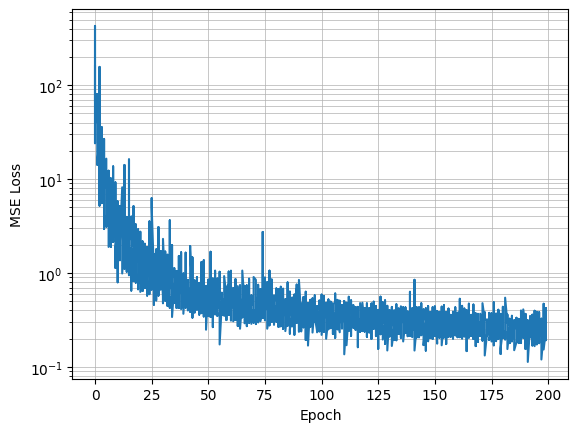

In [268]:
plt.plot(losses['x'], losses['y'])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.grid(which='both', linewidth=0.5)
plt.show()

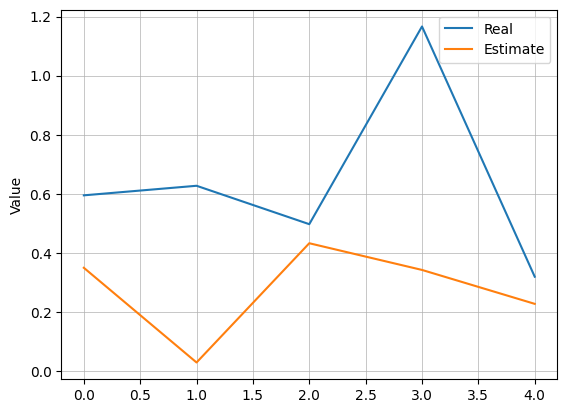

In [285]:
model.eval()

sample = dataset[0]
with torch.no_grad():
    result = model(sample.to(device))

# print('Sample')
# print(sample.y)
# print('Result')
# print(result)

real = sample.y.cpu().flatten().numpy()
estimate = result.cpu().flatten().numpy()

plt.plot(real, label='Real')
plt.plot(estimate, label='Estimate')
plt.ylabel('Value')
plt.legend()
plt.grid(which='both', linewidth=0.5)
plt.show()

Edge update:

``` python
row, col = edge_index
new_edge_attr = self.mlp(torch.cat([x[row], x[col], edge_attr], dim=-1))
```

https://github.com/pyg-team/pytorch_geometric/issues/813

In [95]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__(aggr='mean')  # "mean" aggregation.
        self.lin = torch.nn.Linear(in_channels * 2, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Start propagating messages.
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        # x_i: node features of target nodes
        # x_j: node features of source nodes
        # edge_attr: edge attributes
        return torch.cat([x_i, edge_attr], dim=1)

    def update(self, aggr_out):
        # Update node embeddings
        return self.lin(aggr_out)

# Example usage
from torch_geometric.data import Data

# Create a simple graph
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[1], [2], [3]], dtype=torch.float)
edge_attr = torch.tensor([[1], [2], [3], [4]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Define the convolutional layer
conv = EdgeConv(in_channels=1, out_channels=2)

# Apply the convolutional layer
out = conv(data.x, data.edge_index, data.edge_attr)
print(out)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 7 but got size 4 for tensor number 1 in the list.